<h1 style="text-align: center;" markdown="3">Machine Learning 3: Support Vector Machine Classifier</h1> 

# Table of Contents
[Introduction](#introduction)  
[SVM Classifier](#svm)   
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Calibration with Isotonic Scaling](#calibration)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

Support vector machines (SVM) can be used for supervised classification or regression. At their essence, SVMs perform binary classification by constructing an optimal hyperplane to separate the training data with as big a margin possible. New data are classified according to which side of the hyperplane they fall onto. In this sense, SVMs are _not_ probabilistic models. Nevertheless, SVMs find many applications from image classification to bioinformatics. This is mainly due to SVMs ability to handle high-dimensional data and model _non-linear_ relationships by use of the so-called "[kernel trick](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f)". In the case of the our data, SVMs will be used in their canonical form, as binary classifiers.

## Data setup

As usual, we'll load a the libraries and the data that will be used throughout this notebook. 

In [1]:
# Data importation and manipulation tools
import numpy as np
import pandas as pd
import itertools
import datetime

# Data visualization tools
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Machine Learning tools
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)

In [2]:
# load training data 
lcs_train = pd.read_pickle("Data/processed/train.pkl")

# Separate features
X_train = lcs_train.drop(['Persns_wgt', 'sick'], axis=1)
y_train = lcs_train['sick']
w_train = lcs_train['Persns_wgt']

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent sick: {:0.1%} \tPercent non-sick: {:0.1%}' \
        .format(*y_train.value_counts(normalize=True, ascending=True)))

# Load test data
lcs_test = pd.read_pickle("Data/processed/test.pkl")

# Separate features
X_test = lcs_test.drop(['Persns_wgt', 'sick'], axis=1)
y_test = lcs_test['sick']
y_test = np.ravel(y_test)
w_test = lcs_test['Persns_wgt']

# print first 5 rows of data
X_train.head()

Data has 39,075 rows and 236 columns
Percent sick: 15.9% 	Percent non-sick: 84.1%


,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,48,2,0,0,0,0,0,5,3664.148804,400,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,27,0,0,0,0,0,0,4,11451.292500,1250,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,3,1,1,0,0,3,0,6,6066.745258,1000,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,0,1,1,1,0,0,0,3,28007.446415,2620,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,4,3,1,0,0,0,0,7,1727.626033,285,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Standardize features
def standardize(df):
    cols = df.loc[:, df.dtypes != 'uint8'].columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field] - mean != 0):
            df.loc[:, field] = (df[field] - mean) / std
    
    return df

standardize(X_train)
standardize(X_test)
X_train.head()

,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,0.955936,-0.414011,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.157885,-0.431979,-0.283026,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,-0.052461,-1.779027,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.489928,-0.258849,-0.141051,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,-1.204916,-1.096519,0.262655,-0.582252,-0.528091,1.359649,-0.286177,0.174158,-0.378563,-0.182809,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,-1.348973,-1.096519,0.262655,0.617089,-0.528091,-0.298658,-0.286177,-0.821970,0.109240,0.087779,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,-1.156897,0.268497,0.262655,-0.582252,-0.528091,-0.298658,-0.286177,0.506200,-0.475034,-0.302234,...,0,0,0,0,0,0,0,0,0,0


## Metrics functions
Let's also create our functions for the evaluation of models.

In [4]:
# Create the ROC plot function
def plot_roc(y_test, y_pred, y_prob, model, ax, sample_weights=None):
    
    # dictionnary of metrics to calculate
    fpr, tpr, _ = roc_curve(y_test, y_prob, sample_weight=sample_weights)
    metrics = {}
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    metrics['roc_auc'] = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    
    # Create graph with Legend
    ax= ax
    ax.plot(metrics['fpr'], metrics['tpr'], label='{} AUC = {:0.2f}'.format(model, metrics['roc_auc']))
    
    # Specification of Graph
    ax.set_title('Receiver Operating Characteristic')
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([-0.01,1])
    ax.set_ylim([0,1.01])
    ax.legend(loc='lower right')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return

# Create the confusion matrix plot function
# Derived from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_test, y_pred,ax, sample_weight = None):
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, sample_weight=None)
    # Reverse the results
    cm = cm[::-1,::-1]

    # Create plot
    ax = ax
    tick_marks = np.arange(2)
    ax.set_title('Confusion matrix')
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(["sick", "non-sick"])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(["sick","non-sick"])
    ax.grid(False)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    # Create font and color bar
    im = ax.imshow(cm, interpolation='nearest', cmap= plt.cm.Blues)
    fig.colorbar(im, ax=ax, shrink=0.7)

    # Create normalized and text results
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = "{:.0f}".format(cm[i,j])
        txt = txt + "\n{:0.1%}".format(cm_norm[i,j])
        ax.text(j, i, txt, fontsize=14, fontweight='bold',
                     horizontalalignment="center", verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    return


# Create a DataFrame to store de model results
model_score = pd.DataFrame(index = ['accuracy','recall','precision','f1','roc_auc','cross_entropy','cohen_kappa'])

# Define a function to show metrics in a DataFrame
def get_metrics(y_test, y_pred, model_name, sample_weights=None): 
    # Show metrics values
    model_scores = {}

    model_scores['accuracy']          = accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['recall']            = recall_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['precision']         = precision_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['f1']                = f1_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['roc_auc']           = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    model_scores['cross_entropy']     = log_loss(y_test,y_prob,sample_weight=sample_weights)
    model_scores['cohen_kappa']       = cohen_kappa_score(y_test, y_pred)

    print("Model Scores")
    print("Actual sick rate: {:0.2%}".format(y_test.sum()/len(y_test)))
    print("Predicted sick rate: {:0.2%}".format(y_pred.sum()/len(y_pred)))
    model_score[model_name] = model_score.index.map(model_scores)
    return model_score

# SVM Classifier <a class="anchor" id="svm"></a>

Now let's apply the SVM classifier to the dataset. One of the drawbacks of SVMs is that they are very slow to train on large datasets with large numbers of features. Many of the following cells may take a long time to run.

In [5]:
# Support Vector Machines
from sklearn.svm import SVC

# Time monitoring
begin_time = datetime.datetime.now()

# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]


print(datetime.datetime.now() - begin_time)


/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 11min 59s, sys: 1.49 s, total: 12min
Wall time: 12min 1s
CPU times: user 1min 19s, sys: 58.8 ms, total: 1min 19s
Wall time: 1min 19s
In-sample score: 89.34%
0:14:12.812417


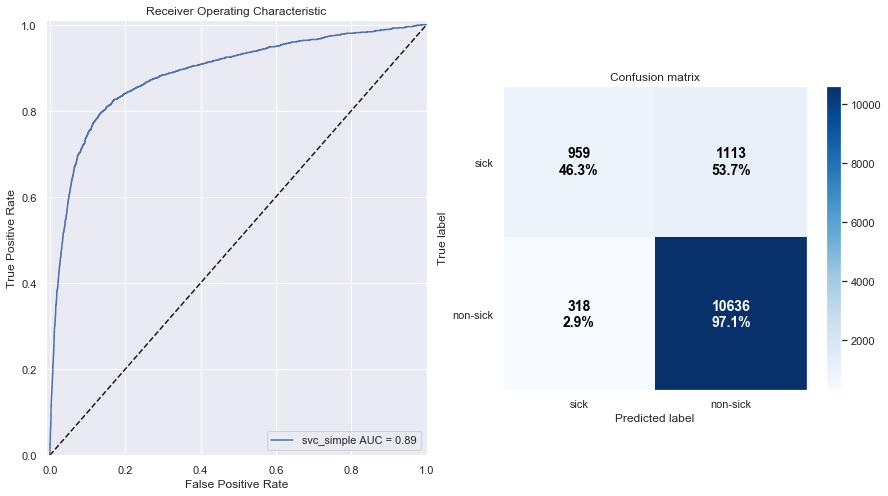

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 9.80%


,svc_simple
accuracy,0.890143
recall,0.462838
precision,0.750979
f1,0.572708
roc_auc,0.887188
cross_entropy,0.289161
cohen_kappa,0.513719


In [6]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "svc_simple", ax= axes[0])
plot_confusion_matrix(y_test, y_pred, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred, 'svc_simple')

Here as usual, we have a good accuracy of 89% but lack of recall with only 46%. We predict only 9.8% rate of sick people but there are 16% of them. Let's try to use re-sampling methods to increase the recall.

## Class Weighting
Since we have the option of using class weights, let's see how it performs with SVM.

NOTE: The following cell may take over an hour to run.

In [7]:
# Time monitoring
begin_time = datetime.datetime.now()

# Fit the model
model = SVC(probability=True, class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Run the model
y_pred_wts = model.predict(X_test)
y_prob_wts = model.predict_proba(X_test)[:,1]


print(datetime.datetime.now() - begin_time)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 23min 34s, sys: 1.72 s, total: 23min 36s
Wall time: 23min 33s
CPU times: user 2min 17s, sys: 102 ms, total: 2min 17s
Wall time: 2min 17s
In-sample score: 87.69%
0:27:23.104997


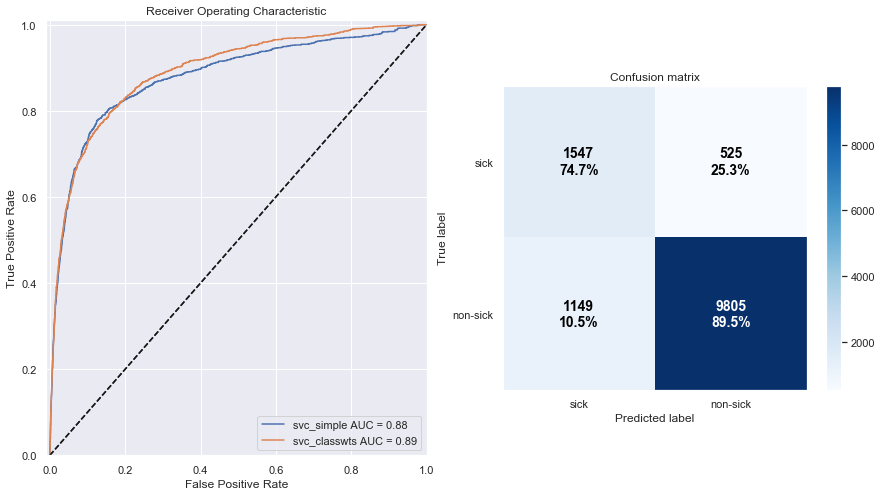

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 20.70%


,svc_simple,svc_classwts
accuracy,0.890143,0.877016
recall,0.462838,0.712507
precision,0.750979,0.548523
f1,0.572708,0.619853
roc_auc,0.887188,0.880102
cross_entropy,0.289161,0.273890
cohen_kappa,0.513719,0.571901


In [8]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "svc_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_wts, y_prob_wts, "svc_classwts", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_wts, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_wts, 'svc_classwts', sample_weights = w_test)

The class weighting increase the recall but decrease precision and the accuracy. The overall f1 is not better than our simple model.

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

In [9]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
X_train_u, y_train_u = RandomUnderSampler().fit_sample(X_train, y_train)

print("X shape after undersampling: ", X_train_u.shape)

# Fit the model
model = SVC(probability=True)
%time model.fit(X_train_u, y_train_u)

# Get an initial score
%time score = model.score(X_train_u, y_train_u)
print("In-sample score: {:0.2%}".format(score))

# Run the model
%time y_pred_u = model.predict(X_test)
%time y_prob_u = model.predict_proba(X_test)[:,1]

Using TensorFlow backend.


X shape after undersampling:  (12430, 236)


/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 1min 39s, sys: 77.7 ms, total: 1min 39s
Wall time: 1min 39s
CPU times: user 15.5 s, sys: 9.37 ms, total: 15.5 s
Wall time: 15.5 s
In-sample score: 81.20%
CPU times: user 16.2 s, sys: 10.4 ms, total: 16.2 s
Wall time: 16.2 s
CPU times: user 16.2 s, sys: 12.6 ms, total: 16.2 s
Wall time: 16.2 s


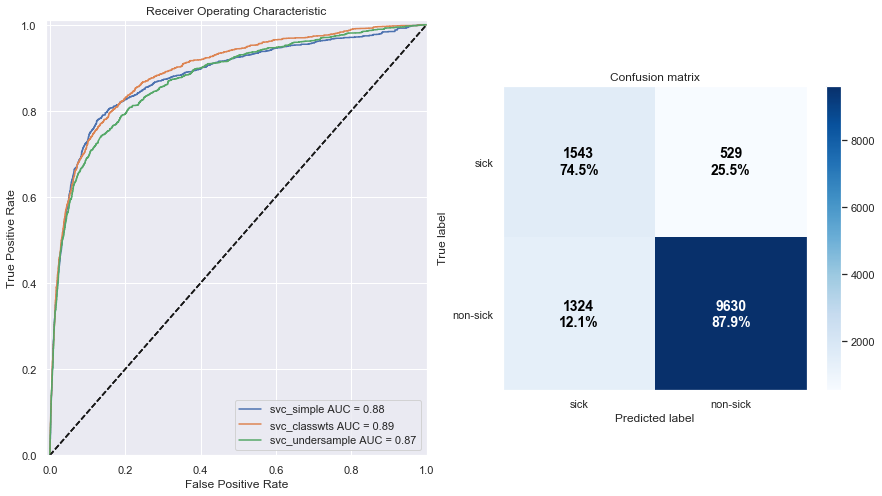

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 22.01%


,svc_simple,svc_classwts,svc_undersample
accuracy,0.890143,0.877016,0.862413
recall,0.462838,0.712507,0.709103
precision,0.750979,0.548523,0.507984
f1,0.572708,0.619853,0.591926
roc_auc,0.887188,0.880102,0.880102
cross_entropy,0.289161,0.273890,0.273890
cohen_kappa,0.513719,0.571901,0.539846


In [10]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "svc_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_wts, y_prob_wts, "svc_classwts", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "svc_undersample", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_u, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_u, 'svc_undersample', sample_weights = w_test)

Undersampling is worse than class weighting in any metrics. So it is not the best method available.

## Oversampling <a class="anchor" id="oversampling">

NOTE: Since oversampling greatly increases the size of the dataset, the following cell will take a very long time to run.

In [11]:
from imblearn.over_sampling import SMOTE

# Apply random undersampling
X_train_o, y_train_o = SMOTE().fit_sample(X_train, y_train)

print("X shape after undersampling: ", X_train_o.shape)

# Fit the model
model = SVC(probability=True)
%time model.fit(X_train_o, y_train_o)

# Get an initial score
%time score = model.score(X_train_o, y_train_o)
print("In-sample score: {:0.2%}".format(score))

# Run the model
%time y_pred_o = model.predict(X_test)
%time y_prob_o = model.predict_proba(X_test)[:,1]

X shape after undersampling:  (65720, 236)


/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 51min 2s, sys: 2.38 s, total: 51min 4s
Wall time: 51min 4s
CPU times: user 6min 4s, sys: 1.08 s, total: 6min 5s
Wall time: 6min 5s
In-sample score: 86.67%
CPU times: user 1min 11s, sys: 59.7 ms, total: 1min 11s
Wall time: 1min 11s
CPU times: user 1min 11s, sys: 53.1 ms, total: 1min 12s
Wall time: 1min 12s


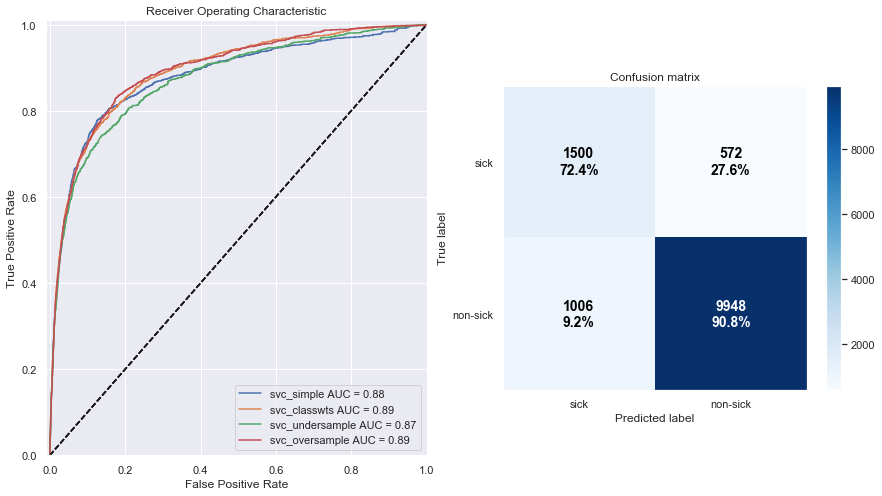

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 19.24%


,svc_simple,svc_classwts,svc_undersample,svc_oversample
accuracy,0.890143,0.877016,0.862413,0.885559
recall,0.462838,0.712507,0.709103,0.698650
precision,0.750979,0.548523,0.507984,0.577141
f1,0.572708,0.619853,0.591926,0.632109
roc_auc,0.887188,0.880102,0.880102,0.880102
cross_entropy,0.289161,0.273890,0.273890,0.273890
cohen_kappa,0.513719,0.571901,0.539846,0.582623


In [12]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "svc_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_wts, y_prob_wts, "svc_classwts", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "svc_undersample", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_o, y_prob_o, "svc_oversample", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_o, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_o, 'svc_oversample', sample_weights = w_test)

Oversampling gives relatively good results. It has a good balance between accuracy and recall. Precision is still a bit low, but better than the other two sampling models. The downside is that it takes a lot of time to train.

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

The SVC model has a single parameter, `C`, we can attempt to tune. This determines the regularization strength. We can also see how different kernels perform. Since SVM takes a long time to train for larger datasets, we'll use undersampling to balance the classes.

NOTE: The following cell may take over an hour to run.

In [26]:
from sklearn.model_selection import GridSearchCV

# build the model
estimator = SVC(probability=True)
parameters = {'C': 10**np.linspace(-3,1,3), 
              'kernel': ['rbf', 'linear']}
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train_u, y_train_u)

# Get an initial score
%time score = model.score(X_train_u, y_train_u)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Run the model
y_pred_cv = model.predict(X_test)
y_prob_cv = model.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.4min finished
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 1min 33s, sys: 581 ms, total: 1min 34s
Wall time: 25min
CPU times: user 14.2 s, sys: 16.4 ms, total: 14.2 s
Wall time: 14.2 s
In-sample score: 85.36%
Best model parameters: {'C': 10.0, 'kernel': 'rbf'}


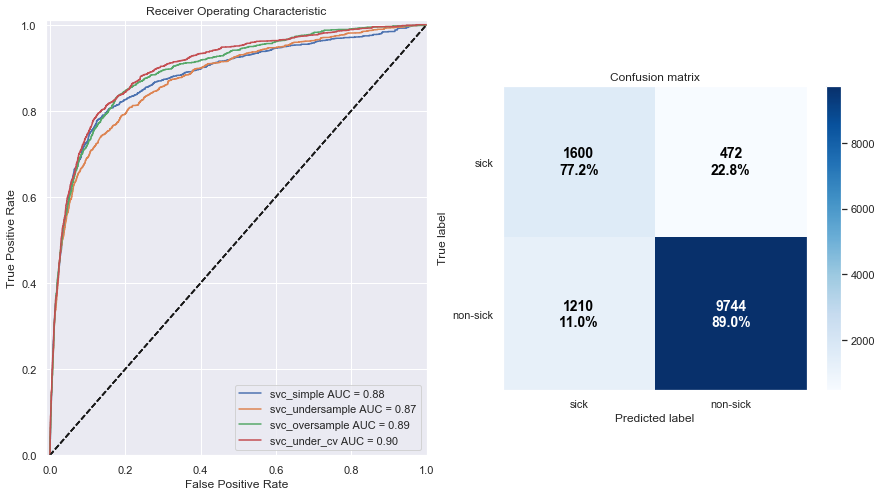

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 21.57%


,svc_simple,svc_classwts,svc_undersample,svc_oversample,svc_under_cv,svc_isotonic
accuracy,0.890143,0.877016,0.862413,0.885559,0.875962,0.855802
recall,0.462838,0.712507,0.709103,0.698650,0.753879,0.816505
precision,0.750979,0.548523,0.507984,0.577141,0.542676,0.492552
f1,0.572708,0.619853,0.591926,0.632109,0.631075,0.614444
roc_auc,0.887188,0.880102,0.880102,0.880102,0.880102,0.880102
cross_entropy,0.289161,0.273890,0.273890,0.273890,0.273890,0.273890
cohen_kappa,0.513719,0.571901,0.539846,0.582623,0.578240,0.553202


In [27]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "svc_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "svc_undersample", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_o, y_prob_o, "svc_oversample", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_cv, y_prob_cv, "svc_under_cv", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_cv, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_cv, 'svc_under_cv', sample_weights = w_test)

Using fine tuning parameter gives better results and allow to have better metrics with undersampling. I would be curious to see how it would perform with oversample. But it would take to much time to increase for just a little bit, so I decided to stay with the undersampling CV.

Let's see how the accuracy evolves in the train and test set according to the different parameter.

In [28]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_C', 'param_kernel']
cv_results[cols].sort_values('mean_test_score', ascending=False)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=T

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_C,param_kernel
4,0.823813,0.005183,0.852957,0.001488,10,rbf
5,0.813435,0.006833,0.817518,0.002455,10,linear
3,0.813194,0.006240,0.817880,0.001380,0.1,linear
1,0.776106,0.003905,0.779867,0.000771,0.001,linear
2,0.770636,0.004823,0.775805,0.001099,0.1,rbf
0,0.739662,0.003673,0.741311,0.001768,0.001,rbf


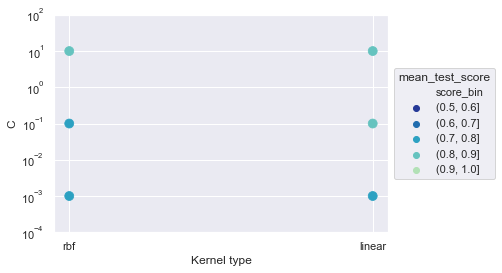

No handles with labels found to put in legend.


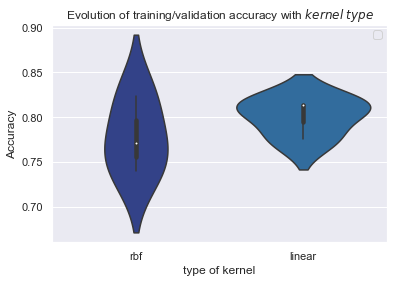

In [50]:
df = pd.DataFrame(
    {
        "C": cv_results["param_C"],
        "Kernel type": cv_results["param_kernel"],
        "score_bin": pd.cut(
            cv_results["mean_test_score"], bins=np.linspace(0.5, 1.0, 6)
        ),
    }
)
sns.set_palette("YlGnBu_r")
ax = sns.scatterplot(
    data=df,
    x="Kernel type",
    y="C",
    hue="score_bin",
    s=80,
    color="k",
    edgecolor=None,
)

ax.set_yscale("log")
ax.set_ylim([0.0001, 100])

_ = ax.legend(title="mean_test_score", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Plot training/validation accuracy curves
sns.violinplot(data=cv_results, x=cv_results["param_kernel"], y=cv_results["mean_test_score"])
plt.xlabel('type of kernel')
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $kernel$ $type$")
plt.legend()
plt.show()

With the graphs, we can define a parameter C at 10 to be in a good range. We could try to improve the model with higher C values such as 100 or 1000.  We see as well that the linear kernel has a better accuracy with less variance tha

# Classifier Calibration with Isotonic Regression <a class="anchor" id="calibration"></a>

We introduced classifier calibration in the Naive Bayes Malawi notebook. Here, we will apply a different type of calibration, isotonic regression, to see if we can improve our model performance. In Scikit-Learn, this simply involves changing the `method` parameter of the CalibratedClassifierCV to 'isotonic'.

In [17]:
from sklearn.calibration import CalibratedClassifierCV

# build the model
estimator = CalibratedClassifierCV(SVC(probability=True), method='isotonic')
parameters = {'base_estimator__C': 10**np.linspace(-3,3,20)}

model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train_u, y_train_u)

# Get an initial score
%time score = model.score(X_train_u, y_train_u)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Run the model
y_pred_iso = model.predict(X_test)
y_prob_iso = model.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 70.0min finished
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of g

CPU times: user 2min 40s, sys: 844 ms, total: 2min 41s
Wall time: 1h 12min 43s
CPU times: user 28.5 s, sys: 26.1 ms, total: 28.5 s
Wall time: 28.5 s
In-sample score: 95.00%
Best model parameters: {'base_estimator__C': 112.88378916846884}


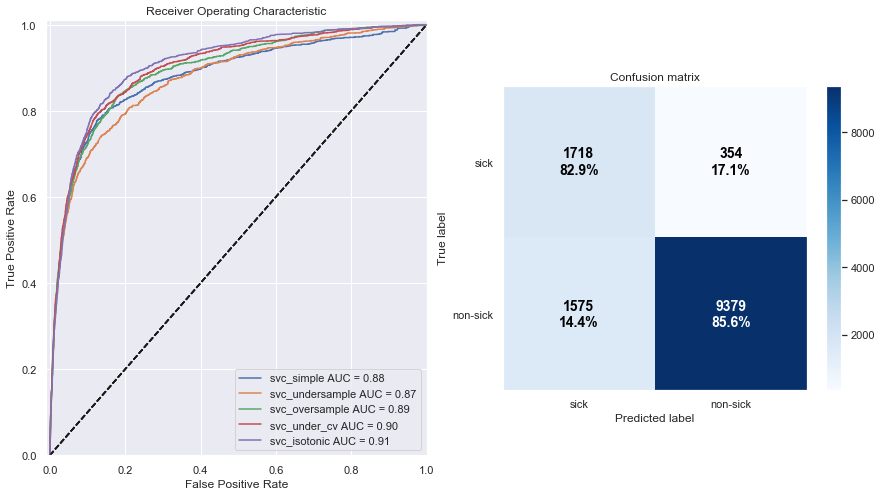

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 25.28%


,svc_simple,svc_classwts,svc_undersample,svc_oversample,svc_under_cv,svc_isotonic
accuracy,0.890143,0.877016,0.862413,0.885559,0.875962,0.855802
recall,0.462838,0.712507,0.709103,0.698650,0.753879,0.816505
precision,0.750979,0.548523,0.507984,0.577141,0.542676,0.492552
f1,0.572708,0.619853,0.591926,0.632109,0.631075,0.614444
roc_auc,0.887188,0.880102,0.880102,0.880102,0.880102,0.880102
cross_entropy,0.289161,0.273890,0.273890,0.273890,0.273890,0.273890
cohen_kappa,0.513719,0.571901,0.539846,0.582623,0.578240,0.553202


In [18]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "svc_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "svc_undersample", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_o, y_prob_o, "svc_oversample", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_cv, y_prob_cv, "svc_under_cv", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_iso, y_prob_iso, "svc_isotonic", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_iso, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_iso, 'svc_isotonic', sample_weights = w_test)

Appliying isotonic regression improve the recall metric, but all other metrics are not good. And the accuracy is not better than our baseline model, although it correctly predict sick people.

Let's again see if there is over or underfitting according to the base estimator C.

In [19]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_base_estimator__C']
cv_results[cols].sort_values('mean_test_score', ascending=False)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=T

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_base_estimator__C
16,0.841432,0.004975,0.954767,0.000871,112.884
15,0.840225,0.003646,0.919389,0.001529,54.5559
17,0.837731,0.008015,0.984312,0.000579,233.572
18,0.834191,0.008792,0.997043,0.000049,483.293
14,0.832904,0.001948,0.888174,0.001264,26.3665
19,0.831778,0.011333,0.999477,0.000173,1000
13,0.828640,0.006511,0.860599,0.001424,12.7427
12,0.821883,0.004252,0.842498,0.001074,6.15848
11,0.813837,0.003945,0.829344,0.000915,2.97635
10,0.805068,0.005092,0.817076,0.001018,1.43845


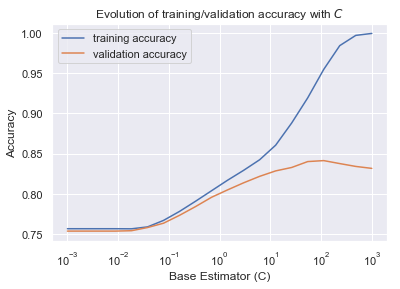

In [20]:
# Plot training/validation accuracy curves
plt.semilogx(cv_results["param_base_estimator__C"], cv_results["mean_train_score"], label='training accuracy')
plt.semilogx(cv_results["param_base_estimator__C"], cv_results["mean_test_score"],  label='validation accuracy')
plt.xlabel('Base Estimator (C)')
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $C$")
plt.legend()
plt.show()

Here, we clearly see that a C estimator above 100 start to overfit the data.

# SVM Summary <a class="anchor" id="summary"></a>



In [21]:
# Inverse the cross entropy values
model_eval = model_score.copy()
model_eval[model_eval.index == 'cross_entropy'] = 1 - model_eval[model_eval.index == 'cross_entropy']

model_eval.mean().sort_values(ascending = False)

svc_under_cv       0.712578
svc_oversample     0.711756
svc_isotonic       0.705531
svc_classwts       0.705144
svc_undersample    0.688212
svc_simple         0.684059
dtype: float64

In [22]:
# Store the results in a pickle file
model_score.to_pickle("models/svm.pkl")